# First version of nucleusj in python

TODO:
- open data and metadata (with bioformat? OMERO?)
- visualise it
- auto-crop: 
    - Ostu threshold 
    - Connected component (MorpholibJ)
    - Component of volume > 1um are conserved
    - A bounding box around each connected component --> plus a 20 voxel surrounding
    - Group bounding boxes if they have a IoU > 0.5
    - Generate a Z-projection with the bouding boxes
    - A tabulated file with the list of each nucleus + bboxes coord in a .txt file
- segmentation:
    - do a thresholding Otsu then the modified Ostu?
    - gift-wrapping 
- surface area computation:
    - discrete geometry technique
    - NAMM: can we use ML to find the right transformation from the sphere images?

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import skimage as sk
from skimage import io
import tifffile as tif
import SimpleITK as sitk
import pandas
import os
import tqdm
from PIL import Image, TiffTags, ImageSequence

from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops

import xml.etree.ElementTree as ET

In [2]:
# paths
img_path = '../data/wide_field.tif'
out_path = '../data/output/'

In [3]:
# open a single image
img = io.imread(img_path)

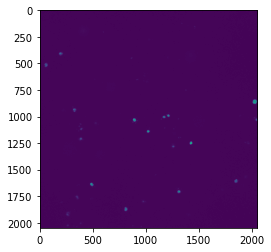

In [4]:
half = len(img)//2
plt.imshow(img[half])

## auto-crop
- Ostu threshold 
- Connected component (MorpholibJ)
- Component of volume > 1um are conserved
- A bounding box around each connected component --> plus a 20 voxel surrounding
- Group bounding boxes if they have a IoU > 0.5
- Generate a Z-projection with the bouding boxes
- A tabulated file with the list of each nucleus + bboxes coord in a .txt file

In [5]:
# ostu threshold
thresh = threshold_otsu(img)
binary = img > thresh

# print("ostu threshold: {}".format(thresh))
# plt.imshow(binary[half])

In [6]:
# connected components
connec = label(binary)
nb_connec = len(np.unique(connec))
print("number of connected components: {}".format(nb_connec))

# plt.imshow(connec[half])

number of connected components: 105


In [7]:
# volume of a connected component
def connec_volume(connec, idx):
    """
    returns the volume in pixel of the connected component of index 'idx' form the image called 'connec'
    """
    return np.sum(connec == idx)

# print the volume of all the connected components in pixel
def connec_volume_all(connec):
    nb_connec = len(np.unique(connec))
    l_connec = []
    for idx, elm in enumerate(np.unique(connec)[1:]): # remove the bg
        l_connec += [connec_volume(connec, elm)]
    return l_connec
l_connec = connec_volume_all(connec)
print(l_connec) # list of all connected component volumes (except of the bg)

[8565, 6242, 8778, 8390, 8166, 21, 5692, 6492, 6646, 7256, 6631, 6167, 24884, 1, 8362, 5479, 7736, 1, 6664, 1, 13, 1, 6049, 5797, 8291, 14, 20, 6727, 6959, 1, 1, 1, 1, 4740, 4291, 1, 6906, 1, 6203, 4243, 1, 2999, 1, 36, 3482, 1, 4, 1, 113, 4366, 2, 1, 3738, 3360, 18351, 6, 1, 1, 1, 2, 2, 1, 1, 1, 4156, 1, 3566, 4408, 1, 1, 2, 1, 1, 1, 2976, 12683, 5696, 1, 1, 57, 1, 1, 1, 2, 4261, 3, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1]


In [8]:
# remove connected component that are too small
# criteria (arbitrari): below 1000 pixel are removed

connec_clean = np.zeros_like(connec)
for idx, elm in enumerate(l_connec):
    if elm > 1000:
        connec_clean += (connec==(idx+1)).astype(int)*(idx+1)

# l_connec_clean = connec_volume_all(connec_clean)
# print(l_connec_clean)

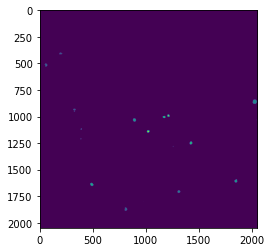

In [9]:
plt.imshow(connec_clean[half])

In [10]:
# crop each connected components by a frame of 20 pixel and save them as tif files
props = regionprops(connec_clean) 

def crop_bbox(img, bbox, margin=20):
    """
    bbox: (ax,ay,az,bx,by,bz)
    """
    # adds margin and assert it is in the right range
    bbox_a = np.array(bbox)[:3]-margin
    bbox_b = np.array(bbox)[3:]+margin
    bbox_ = np.append(bbox_a, bbox_b)
    im_shape = img.shape

    for i in range(2):
        for j in range(3):
            if bbox_[i*3+j] >= img.shape[j]:
                bbox_[i*3+j] = img.shape[j] - 1
            elif bbox_[i*3+j] < 0:
                bbox_[i*3+j] = 0
    ax,ay,az,bx,by,bz = np.array(bbox_)
    return img[ax:bx,ay:by,az:bz], np.array(bbox_)

In [11]:
# io.use_plugin('freeimage')
img_bits = int(2**(2**np.ceil(np.log2(np.ceil(np.log2(np.max(img)))))))


def link_metadata(array, im, out_path):
    """
    link the metadata contained in 'im' (a PIL.Image) to the numpy.array 'array' and save it in 'out_path'
    """
    # convert array to image
    frames = []
#     for i, frame in enumerate(ImageSequence.Iterator(im)):
    for i in range(len(array)):
        
        frame = Image.fromarray(array[i])
#         print({TAGS[key] : frame.tag[key] for key in frame.tag.iterkeys()})
#         print(frame.tag[256])
#         print(type(frame.tag[256]))
#         frame.tag[256] = (array.shape[1],) # image width
#         frame.tag[257] = (array.shape[2],) # image length
        
#         frame = frame.copy()
#         frame.tag[256] = (array.shape[1],) # image width
#         frame.tag[257] = (array.shape[2],) # image length
        frames.append(frame)
        
        
    
    del im.tag[286]
    im.tag[256] = (array.shape[2],) # image width
    im.tag[257] = (array.shape[1],) # image length
#     im.tag[32997] = 0.2
    frames[0].save(out_path, tiffinfo=im.tag, save_all=True, append_images=frames[1:])


i = 0
connec_crop, bbox = crop_bbox(connec_clean, props[i].bbox)
connec_crop = ((connec_crop / np.max(connec_crop)) * (img_bits-1)).astype(np.uint16)

fname = out_path + str(i) + '.tif'

im = Image.open(img_path)

# meta_dict = {TAGS[key] : im.tag[key] for key in im.tag.iterkeys()}
# print(meta_dict)
link_metadata(connec_crop, im, fname)

    
#     for i in range(len(props)):
#         connec_crop, bbox = crop_bbox(connec_clean, props[i].bbox)
#         connec_crop = ((connec_crop / np.max(connec_crop)) * (img_bits-1)).astype(np.uint16)

#         fname = out_path + str(i) + '.tif'
    
#         region = im.crop(bbox)
#         region.save(fname)
        
#     io.imsave(fname, connec_crop)
#     bioformats.write_image(fname, connec_crop, bioformats.PT_UINT16)
#     img_itk = sitk.GetImageFromArray(connec_crop)
#     img_itk.SetSpacing(np.array((0.2e-3, 0.1032e-3,0.1032e-3))[::-1])
#     sitk.WriteImage(img_itk, fname)

### tifffile?

In [12]:
# this one solution is very close to what is expected!
img_path = '../data/wide_field.tif'
tim = tif.TiffFile(img_path)
for page in tim.pages:
    for tag in page.tags:
        tag_name, tag_value = tag.name, tag.value
        print(tag_name, tag_value)

NewSubfileType FILETYPE.PAGE
ImageWidth 2048
ImageLength 2048
BitsPerSample 16
Compression COMPRESSION.NONE
PhotometricInterpretation PHOTOMETRIC.MINISBLACK
ImageDescription <MetaData>
<prop id="Description" type="string" value="Exposure: 60 ms&#13;&#10;Binning: 1 x 1&#13;&#10;Region: 2048 x 2048, offset at (0, 0)&#13;&#10;Subtract: Off&#13;&#10;Shading: Off&#13;&#10;Digitizer: High-precision (16-bit)&#13;&#10;Bit Depth: 16&#13;&#10;Frames to Average: 1&#13;&#10;Trigger Mode: Internal&#13;&#10;Number of trigger times: 1&#13;&#10;Output Trigger 1: LOW&#13;&#10;Output Trigger Delay 1: -0 msec&#13;&#10;Output Trigger Width 1: 0.001 msec&#13;&#10;Output Trigger 2: LOW&#13;&#10;Output Trigger 2 Delay: -0 msec&#13;&#10;Output Trigger 2 Width: 1e-006 msec&#13;&#10;Output Trigger 3: LOW&#13;&#10;Output Trigger 3 Delay: -0 msec&#13;&#10;Output Trigger 3 Width: 1e-006 msec&#13;&#10;Electron Count Conversion Factor: 0.49&#13;&#10;Electron Count Conversion Offset: 100&#13;&#10;&#13;&#10;"/>
<prop 

NewSubfileType FILETYPE.PAGE
ImageWidth 2048
ImageLength 2048
BitsPerSample 16
Compression COMPRESSION.NONE
PhotometricInterpretation PHOTOMETRIC.MINISBLACK
ImageDescription <MetaData>
<prop id="Description" type="string" value="Exposure: 60 ms&#13;&#10;Binning: 1 x 1&#13;&#10;Region: 2048 x 2048, offset at (0, 0)&#13;&#10;Subtract: Off&#13;&#10;Shading: Off&#13;&#10;Digitizer: High-precision (16-bit)&#13;&#10;Bit Depth: 16&#13;&#10;Frames to Average: 1&#13;&#10;Trigger Mode: Internal&#13;&#10;Number of trigger times: 1&#13;&#10;Output Trigger 1: LOW&#13;&#10;Output Trigger Delay 1: -0 msec&#13;&#10;Output Trigger Width 1: 0.001 msec&#13;&#10;Output Trigger 2: LOW&#13;&#10;Output Trigger 2 Delay: -0 msec&#13;&#10;Output Trigger 2 Width: 1e-006 msec&#13;&#10;Output Trigger 3: LOW&#13;&#10;Output Trigger 3 Delay: -0 msec&#13;&#10;Output Trigger 3 Width: 1e-006 msec&#13;&#10;Electron Count Conversion Factor: 0.49&#13;&#10;Electron Count Conversion Offset: 100&#13;&#10;&#13;&#10;"/>
<prop 

In [44]:
test_path = '../data/output/0.tif'
te = Image.open(test_path)
print(te.tag)

{256: (2048,), 257: (2048,), 258: (16,), 259: (1,), 262: (1,), 270: ('ImageJ=1.11a\nimages=75\nchannels=75\nhyperstack=true\nmode=grayscale\nnewsubfiletype=2\nimagewidth=2048\nimagelength=2048\nbitspersample=16\ncompression=1\nphotometricinterpretation=1\nimagedescription=<MetaData>\n<prop id="Description" type="string" value="Exposure: 60 ms&#13;&#10;Binning: 1 x 1&#13;&#10;Region: 2048 x 2048, offset at (0, 0)&#13;&#10;Subtract: Off&#13;&#10;Shading: Off&#13;&#10;Digitizer: High-precision (16-bit)&#13;&#10;Bit Depth: 16&#13;&#10;Frames to Average: 1&#13;&#10;Trigger Mode: Internal&#13;&#10;Number of trigger times: 1&#13;&#10;Output Trigger 1: LOW&#13;&#10;Output Trigger Delay 1: -0 msec&#13;&#10;Output Trigger Width 1: 0.001 msec&#13;&#10;Output Trigger 2: LOW&#13;&#10;Output Trigger 2 Delay: -0 msec&#13;&#10;Output Trigger 2 Width: 1e-006 msec&#13;&#10;Output Trigger 3: LOW&#13;&#10;Output Trigger 3 Delay: -0 msec&#13;&#10;Output Trigger 3 Width: 1e-006 msec&#13;&#10;Electron Count 

In [13]:
test_path = '../data/wide_field.tif'
te1 = Image.open(test_path)
# print(te1.tag)
test_path = '../data/output/0.tif'
te2 = Image.open(test_path)
# print(te2.tag)
for k, v in te1.tag.items():
    if k not in te2.tag.keys() or v not in te2.tag.values():
        print(k, v)
        print(te2.tag[k])
print(te1.tag==te2.tag)

256 (2048,)
(53,)
257 (2048,)
(69,)
273 (8, 8200, 16392, 24584, 32776, 40968, 49160, 57352, 65544, 73736, 81928, 90120, 98312, 106504, 114696, 122888, 131080, 139272, 147464, 155656, 163848, 172040, 180232, 188424, 196616, 204808, 213000, 221192, 229384, 237576, 245768, 253960, 262152, 270344, 278536, 286728, 294920, 303112, 311304, 319496, 327688, 335880, 344072, 352264, 360456, 368648, 376840, 385032, 393224, 401416, 409608, 417800, 425992, 434184, 442376, 450568, 458760, 466952, 475144, 483336, 491528, 499720, 507912, 516104, 524296, 532488, 540680, 548872, 557064, 565256, 573448, 581640, 589832, 598024, 606216, 614408, 622600, 630792, 638984, 647176, 655368, 663560, 671752, 679944, 688136, 696328, 704520, 712712, 720904, 729096, 737288, 745480, 753672, 761864, 770056, 778248, 786440, 794632, 802824, 811016, 819208, 827400, 835592, 843784, 851976, 860168, 868360, 876552, 884744, 892936, 901128, 909320, 917512, 925704, 933896, 942088, 950280, 958472, 966664, 974856, 983048, 991240, 9

## A temp solution

In [ ]:
def link_metadata(original_img, destination_img):
    tim = tif.TiffFile(original_img)
    tiw = tif.TiffWriter(destination_img)
    for i, frame in enumerate(tim.pages):
        image = frame.asarray()
        metadata = {}
        extratags = []
        
        for tag in frame.tags:
            metadata[tag.name] = tag.value
            if tag.name != 'ImageDescription':
                extratags += [(tag.name, 's', 0, str(tag.value), True)]
        
        desc = metadata['ImageDescription']
        del metadata['ImageDescription']
        tiw.write(image, extratags=extratags, description=desc)
        
    tiw.close()
    tim.close()

In [38]:
# this one solution is very close to what is expected!
img_path = '../data/wide_field.tif'
tim = tif.TiffFile(img_path)
for page in tim.pages:
    for tag in page.tags:
        tag_name, tag_value = tag.name, tag.value
#         print(tag_name, tag_value)


# test_path = '../data/output/0.ome.tif'
# tiw = tif.TiffWriter(test_path, ome=True)
test_path = '../data/output/0.tif'
tiw = tif.TiffWriter(test_path)

for i, frame in enumerate(tim.pages):
    image = frame.asarray()
#     axes = 
    metadata = {}
    extratags = []
    for tag in frame.tags:
        metadata[tag.name] = tag.value
        print(type(tag.value))
        if tag.name != 'ImageDescription':
            extratags += [(tag.name, 's', 0, str(tag.value), True)]
    desc = metadata['ImageDescription']
#     print(extratags)
#     print(desc)
#     xml = ET.fromstring(desc)
#     print(xml[1].attrib)
    del metadata['ImageDescription']
#     print(metadata)
#     tiw.write(image, metadata=metadata, description=desc)
    tiw.write(image, extratags=extratags, description=desc)
    print("saved frame {}".format(i))
help(tiw.write)


# tif.transpose_axes(ij_hyperstack, axes, 'TZCYXS')
tiw.close()

tim.close()

<enum 'FILETYPE'>
<class 'int'>
<class 'int'>
<class 'int'>
<enum 'COMPRESSION'>
<enum 'PHOTOMETRIC'>
<class 'str'>
<class 'tuple'>
<enum 'ORIENTATION'>
<class 'int'>
<class 'int'>
<class 'tuple'>
<class 'str'>
<class 'str'>
saved frame 0
<enum 'FILETYPE'>
<class 'int'>
<class 'int'>
<class 'int'>
<enum 'COMPRESSION'>
<enum 'PHOTOMETRIC'>
<class 'str'>
<class 'tuple'>
<enum 'ORIENTATION'>
<class 'int'>
<class 'int'>
<class 'tuple'>
<class 'str'>
<class 'str'>
saved frame 1
<enum 'FILETYPE'>
<class 'int'>
<class 'int'>
<class 'int'>
<enum 'COMPRESSION'>
<enum 'PHOTOMETRIC'>
<class 'str'>
<class 'tuple'>
<enum 'ORIENTATION'>
<class 'int'>
<class 'int'>
<class 'tuple'>
<class 'str'>
<class 'str'>
saved frame 2
<enum 'FILETYPE'>
<class 'int'>
<class 'int'>
<class 'int'>
<enum 'COMPRESSION'>
<enum 'PHOTOMETRIC'>
<class 'str'>
<class 'tuple'>
<enum 'ORIENTATION'>
<class 'int'>
<class 'int'>
<class 'tuple'>
<class 'str'>
<class 'str'>
saved frame 3
<enum 'FILETYPE'>
<class 'int'>
<class 'int'

saved frame 34
<enum 'FILETYPE'>
<class 'int'>
<class 'int'>
<class 'int'>
<enum 'COMPRESSION'>
<enum 'PHOTOMETRIC'>
<class 'str'>
<class 'tuple'>
<enum 'ORIENTATION'>
<class 'int'>
<class 'int'>
<class 'tuple'>
<class 'str'>
<class 'str'>
saved frame 35
<enum 'FILETYPE'>
<class 'int'>
<class 'int'>
<class 'int'>
<enum 'COMPRESSION'>
<enum 'PHOTOMETRIC'>
<class 'str'>
<class 'tuple'>
<enum 'ORIENTATION'>
<class 'int'>
<class 'int'>
<class 'tuple'>
<class 'str'>
<class 'str'>
saved frame 36
<enum 'FILETYPE'>
<class 'int'>
<class 'int'>
<class 'int'>
<enum 'COMPRESSION'>
<enum 'PHOTOMETRIC'>
<class 'str'>
<class 'tuple'>
<enum 'ORIENTATION'>
<class 'int'>
<class 'int'>
<class 'tuple'>
<class 'str'>
<class 'str'>
saved frame 37
<enum 'FILETYPE'>
<class 'int'>
<class 'int'>
<class 'int'>
<enum 'COMPRESSION'>
<enum 'PHOTOMETRIC'>
<class 'str'>
<class 'tuple'>
<enum 'ORIENTATION'>
<class 'int'>
<class 'int'>
<class 'tuple'>
<class 'str'>
<class 'str'>
saved frame 38
<enum 'FILETYPE'>
<class 

In [36]:
for e in tif.TIFF.DATATYPES:
    print(e)

DATATYPES.BYTE
DATATYPES.ASCII
DATATYPES.SHORT
DATATYPES.LONG
DATATYPES.RATIONAL
DATATYPES.SBYTE
DATATYPES.UNDEFINED
DATATYPES.SSHORT
DATATYPES.SLONG
DATATYPES.SRATIONAL
DATATYPES.FLOAT
DATATYPES.DOUBLE
DATATYPES.IFD
DATATYPES.UNICODE
DATATYPES.COMPLEX
DATATYPES.LONG8
DATATYPES.SLONG8
DATATYPES.IFD8


In [56]:
img_path = '../data/output/0.tif'
tim = tif.TiffFile(img_path)
for page in tim.pages:
    for tag in page.tags:
        tag_name, tag_value = tag.name, tag.value
        print(tag_name, tag_value)

ImageWidth 2048
ImageLength 2048
BitsPerSample 16
Compression COMPRESSION.NONE
PhotometricInterpretation PHOTOMETRIC.MINISBLACK
ImageDescription <MetaData>
<prop id="Description" type="string" value="Exposure: 60 ms&#13;&#10;Binning: 1 x 1&#13;&#10;Region: 2048 x 2048, offset at (0, 0)&#13;&#10;Subtract: Off&#13;&#10;Shading: Off&#13;&#10;Digitizer: High-precision (16-bit)&#13;&#10;Bit Depth: 16&#13;&#10;Frames to Average: 1&#13;&#10;Trigger Mode: Internal&#13;&#10;Number of trigger times: 1&#13;&#10;Output Trigger 1: LOW&#13;&#10;Output Trigger Delay 1: -0 msec&#13;&#10;Output Trigger Width 1: 0.001 msec&#13;&#10;Output Trigger 2: LOW&#13;&#10;Output Trigger 2 Delay: -0 msec&#13;&#10;Output Trigger 2 Width: 1e-006 msec&#13;&#10;Output Trigger 3: LOW&#13;&#10;Output Trigger 3 Delay: -0 msec&#13;&#10;Output Trigger 3 Width: 1e-006 msec&#13;&#10;Electron Count Conversion Factor: 0.49&#13;&#10;Electron Count Conversion Offset: 100&#13;&#10;&#13;&#10;"/>
<prop id="MetaDataVersion" type="fl

ImageWidth 2048
ImageLength 2048
BitsPerSample 16
Compression COMPRESSION.NONE
PhotometricInterpretation PHOTOMETRIC.MINISBLACK
ImageDescription <MetaData>
<prop id="Description" type="string" value="Exposure: 60 ms&#13;&#10;Binning: 1 x 1&#13;&#10;Region: 2048 x 2048, offset at (0, 0)&#13;&#10;Subtract: Off&#13;&#10;Shading: Off&#13;&#10;Digitizer: High-precision (16-bit)&#13;&#10;Bit Depth: 16&#13;&#10;Frames to Average: 1&#13;&#10;Trigger Mode: Internal&#13;&#10;Number of trigger times: 1&#13;&#10;Output Trigger 1: LOW&#13;&#10;Output Trigger Delay 1: -0 msec&#13;&#10;Output Trigger Width 1: 0.001 msec&#13;&#10;Output Trigger 2: LOW&#13;&#10;Output Trigger 2 Delay: -0 msec&#13;&#10;Output Trigger 2 Width: 1e-006 msec&#13;&#10;Output Trigger 3: LOW&#13;&#10;Output Trigger 3 Delay: -0 msec&#13;&#10;Output Trigger 3 Width: 1e-006 msec&#13;&#10;Electron Count Conversion Factor: 0.49&#13;&#10;Electron Count Conversion Offset: 100&#13;&#10;&#13;&#10;"/>
<prop id="MetaDataVersion" type="fl

In [110]:
img_path = '../data/wide_field.tif'
# img_path = '../data/output/0.tif'
tim = tif.TiffFile(img_path)
for page in tim.pages:
    for tag in page.tags:
        tag_name, tag_value = tag.name, tag.value
#         print(tag_name, tag_value)


test_path = '../data/output/0.tif'
tiw = tif.TiffWriter(test_path)

for frame in tim.pages:
    image = frame.asarray()
    metadata = {}
    for tag in frame.tags:
        metadata[tag.name] = tag.value
#         print(tag.name)
#         if tag.name == "ImageDescription":
#             print(repr(metadata[tag.name]))
#             metadata[tag.name]=repr(tag.value)
#             val = tag.value.replace('\"','')
#             metadata[tag.name] = tag.value.decode('string_escape')
                
#             print(str(metadata[tag.name]))
    tiw.write(image, contiguous=True, metadata=metadata)

# volume = tif.asarray()
# for i in range()
    
tim.close()
tiw.close()

In [109]:
img_path = '../data/wide_field_copy.tif'
# img_path = '../data/output/0.tif'
tim = tif.TiffFile(img_path, mode='r+b')
for page in tim.pages:
    for tag in page.tags:
        tag_name, tag_value = tag.name, tag.value
        tag.overwrite("")
        print(tag_name, tag_value)


# test_path = '../data/output/0.tif'
# tiw = tif.TiffFile(test_path, mode='r+b')
# for page in tiw.pages:
#     for tag in page.tags:
#         tag_name, tag_value = tag.name, tag.value
#         print(tag_name, tag_value)

# for i, frame in enumerate(tiw.pages):
#     for tag in tim.pages[i].tags:
#         _ = frame.tags[tag.name].overwrite(tag.value)

# # volume = tif.asarray()
# # for i in range()
    

# tiw.close()
tim.close()

TypeError: slice indices must be integers or None or have an __index__ method

In [119]:
img_path = '../data/wide_field.tif'

tim = tif.TiffFile(img_path)

output = '../data/output/0.tif'

tiw = tif.TiffWriter(output)

tiw.write(tim)

TypeError: float() argument must be a string or a number, not 'TiffFile'

TiffFile 'wide_field.tif'  601.01 MiB  metaseries multipage  75 Pages

TiffPageSeries 0  75x2048x2048  uint16  IYX  Uniform  75 Pages

TiffPage 0 @8388616  2048x2048  uint16  minisblack metaseries multipage memmappable

TiffTag 254 NewSubfileType @8388618 LONG @8388626 PAGE
TiffTag 256 ImageWidth @8388630 SHORT @8388638 2048
TiffTag 257 ImageLength @8388642 SHORT @8388650 2048
TiffTag 258 BitsPerSample @8388654 SHORT @8388662 16
TiffTag 259 Compression @8388666 SHORT @8388674 NONE
TiffTag 262 PhotometricInterpretation @8388678 SHORT @8388686 MINISBLACK
TiffTag 270 ImageDescription @8388690 ASCII[5790] @8388790 <MetaData> <prop id=
TiffTag 273 StripOffsets @8388702 LONG[1024] @8394580 (8, 8200, 16392, 24584, 3
TiffTag 274 Orientation @8388714 SHORT @8388722 TOPLEFT
TiffTag 277 SamplesPerPixel @8388726 SHORT @8388734 1
TiffTag 278 RowsPerStrip @8388738 SHORT @8388746 2
TiffTag 279 StripByteCounts @8388750 LONG[1024] @8398676 (8192, 8192, 8192, 819
TiffTag 305 Software @8388762 ASCII[11] 

KeyError: 'XResolution'

### PIL?

In [40]:
im.tag[256]

(2048,)

In [118]:
## with the code below I keep the x and y informations but not the z one... 
im = Image.open(img_path)
tags=im.tag
frames = []
for i, frame in enumerate(ImageSequence.Iterator(im)):
    frame = frame.copy()
    frames.append(frame)
frames[0].save('../data/rot.tif', tiffinfo=im.tag, save_all=True, append_images=frames[1:])

In [ ]:
from PIL import Image, ImageSequence
path = 'sample.tiff'

im = Image.open(path)
frames = []
for i, frame in enumerate(ImageSequence.Iterator(im)):
    frame = frame.copy()

    # Perform an operation, for example, rotate the second frame
    if i == 1:
        frame = frame.rotate(5)

    frames.append(frame)
del im.tag[286]
frames[0].save('../data/rot.tif', tiffinfo=im.tag, save_all=True, append_images=frames[1:])

### PIL and tifffile

In [135]:
test_path = '../data/wide_field.tif'
te1 = Image.open(test_path)
tags = []
for i, frame in enumerate(ImageSequence.Iterator(te1)):
    tags += [frame.tag]

In [164]:
tif.TIFF.DATA_DTYPES

{'B': 1,
 's': 2,
 'H': 3,
 'I': 4,
 '2I': 5,
 'b': 6,
 'h': 8,
 'i': 9,
 '2i': 10,
 'f': 11,
 'd': 12,
 'Q': 16,
 'q': 17}

In [190]:
print(tif.TIFF.TAGS[257])

ImageLength


In [162]:
list(tif.TIFF.DATATYPES)

[<DATATYPES.BYTE: 1>,
 <DATATYPES.ASCII: 2>,
 <DATATYPES.SHORT: 3>,
 <DATATYPES.LONG: 4>,
 <DATATYPES.RATIONAL: 5>,
 <DATATYPES.SBYTE: 6>,
 <DATATYPES.UNDEFINED: 7>,
 <DATATYPES.SSHORT: 8>,
 <DATATYPES.SLONG: 9>,
 <DATATYPES.SRATIONAL: 10>,
 <DATATYPES.FLOAT: 11>,
 <DATATYPES.DOUBLE: 12>,
 <DATATYPES.IFD: 13>,
 <DATATYPES.UNICODE: 14>,
 <DATATYPES.COMPLEX: 15>,
 <DATATYPES.LONG8: 16>,
 <DATATYPES.SLONG8: 17>,
 <DATATYPES.IFD8: 18>]

In [142]:
print(tags[0])

{256: (2048,), 257: (2048,), 258: (16,), 259: (1,), 262: (1,), 270: ('<MetaData>\n<prop id="Description" type="string" value="Exposure: 60 ms&#13;&#10;Binning: 1 x 1&#13;&#10;Region: 2048 x 2048, offset at (0, 0)&#13;&#10;Subtract: Off&#13;&#10;Shading: Off&#13;&#10;Digitizer: High-precision (16-bit)&#13;&#10;Bit Depth: 16&#13;&#10;Frames to Average: 1&#13;&#10;Trigger Mode: Internal&#13;&#10;Number of trigger times: 1&#13;&#10;Output Trigger 1: LOW&#13;&#10;Output Trigger Delay 1: -0 msec&#13;&#10;Output Trigger Width 1: 0.001 msec&#13;&#10;Output Trigger 2: LOW&#13;&#10;Output Trigger 2 Delay: -0 msec&#13;&#10;Output Trigger 2 Width: 1e-006 msec&#13;&#10;Output Trigger 3: LOW&#13;&#10;Output Trigger 3 Delay: -0 msec&#13;&#10;Output Trigger 3 Width: 1e-006 msec&#13;&#10;Electron Count Conversion Factor: 0.49&#13;&#10;Electron Count Conversion Offset: 100&#13;&#10;&#13;&#10;"/>\n<prop id="MetaDataVersion" type="float" value="1"/>\n<prop id="ApplicationName" type="string" value="MetaMor

In [165]:
tif.TIFF.DATATYPES.LONG

<DATATYPES.LONG: 4>

In [170]:
reformat = []
for i in range(len(tags)):
    tmp = []
    for k, v in tags[i].items():
        if type(v[0])==int and len(v)==1:
            ty = tif.TIFF.DATATYPES.LONG 
            tmp += [(k,ty,1,v[0],True)]
        else:
            ty = tif.TIFF.DATATYPES.BYTE
            tmp += [(k,ty,len(v),v,True)]
    reformat += [tmp]

In [174]:
print(*reformat[0])

(256, <DATATYPES.LONG: 4>, 1, 2048, True) (257, <DATATYPES.LONG: 4>, 1, 2048, True) (258, <DATATYPES.LONG: 4>, 1, 16, True) (259, <DATATYPES.LONG: 4>, 1, 1, True) (262, <DATATYPES.LONG: 4>, 1, 1, True) (270, <DATATYPES.BYTE: 1>, 1, ('<MetaData>\n<prop id="Description" type="string" value="Exposure: 60 ms&#13;&#10;Binning: 1 x 1&#13;&#10;Region: 2048 x 2048, offset at (0, 0)&#13;&#10;Subtract: Off&#13;&#10;Shading: Off&#13;&#10;Digitizer: High-precision (16-bit)&#13;&#10;Bit Depth: 16&#13;&#10;Frames to Average: 1&#13;&#10;Trigger Mode: Internal&#13;&#10;Number of trigger times: 1&#13;&#10;Output Trigger 1: LOW&#13;&#10;Output Trigger Delay 1: -0 msec&#13;&#10;Output Trigger Width 1: 0.001 msec&#13;&#10;Output Trigger 2: LOW&#13;&#10;Output Trigger 2 Delay: -0 msec&#13;&#10;Output Trigger 2 Width: 1e-006 msec&#13;&#10;Output Trigger 3: LOW&#13;&#10;Output Trigger 3 Delay: -0 msec&#13;&#10;Output Trigger 3 Width: 1e-006 msec&#13;&#10;Electron Count Conversion Factor: 0.49&#13;&#10;Electr

In [175]:
PIL.ExifTags.TAGS

NameError: name 'PIL' is not defined

In [176]:
test_path = '../data/wide_field.tif'
te1 = Image.open(test_path)
# print(te1.tag)

test_path = '../data/output/0.ome.tif'
tiw = tif.TiffWriter(test_path, imagej=True)

for i, frame in enumerate(ImageSequence.Iterator(te1)):
    image = np.array(frame.copy())
#     metadata = {}
#     for tag in frame.tags:
#         metadata[tag.name] = tag.value
    print(i)
    tiw.write(image, contiguous=True, extratags=reformat[i])
    
tiw.close()

0


error: required argument is not an integer

### retry with tifffile

In [69]:
# test_path = '../data/wide_field.tif'
test_path = '../data/output/0.tif'
te1 = Image.open(test_path)
list_meta_pil = []
for k, v in te1.tag.items():
    desc = tif.TIFF.TAGS[k]
    print(desc, v)
    list_meta_pil += [desc]

UnidentifiedImageError: cannot identify image file '../data/output/0.tif'

In [48]:
test_path = '../data/output/0.tif'
te1 = Image.open(test_path)
list_meta_pil = []
for k, v in te1.tag.items():
    desc = tif.TIFF.TAGS[k]
#     print(desc, v)
    list_meta_pil += [desc]
print(list_meta_pil)

['ImageWidth', 'ImageLength', 'BitsPerSample', 'Compression', 'PhotometricInterpretation', 'ImageDescription', 'StripOffsets', 'Software', 'SamplesPerPixel', 'RowsPerStrip', 'StripByteCounts']


In [21]:
img_path = '../data/wide_field.tif'
tim = tif.TiffFile(img_path)
metadata = []

for page in tim.pages:
    count = 0
    list_meta_tif = []
    crt_meta = {}
    for tag in page.tags:
        tag_name, tag_value = tag.name, tag.value
        crt_meta[tag_name] = tag_value
        print(count, tag_name, tag_value)
        count += 1
        list_meta_tif += [tag_name]
    metadata += [crt_meta]
    

0 NewSubfileType FILETYPE.PAGE
1 ImageWidth 2048
2 ImageLength 2048
3 BitsPerSample 16
4 Compression COMPRESSION.NONE
5 PhotometricInterpretation PHOTOMETRIC.MINISBLACK
6 ImageDescription <MetaData>
<prop id="Description" type="string" value="Exposure: 60 ms&#13;&#10;Binning: 1 x 1&#13;&#10;Region: 2048 x 2048, offset at (0, 0)&#13;&#10;Subtract: Off&#13;&#10;Shading: Off&#13;&#10;Digitizer: High-precision (16-bit)&#13;&#10;Bit Depth: 16&#13;&#10;Frames to Average: 1&#13;&#10;Trigger Mode: Internal&#13;&#10;Number of trigger times: 1&#13;&#10;Output Trigger 1: LOW&#13;&#10;Output Trigger Delay 1: -0 msec&#13;&#10;Output Trigger Width 1: 0.001 msec&#13;&#10;Output Trigger 2: LOW&#13;&#10;Output Trigger 2 Delay: -0 msec&#13;&#10;Output Trigger 2 Width: 1e-006 msec&#13;&#10;Output Trigger 3: LOW&#13;&#10;Output Trigger 3 Delay: -0 msec&#13;&#10;Output Trigger 3 Width: 1e-006 msec&#13;&#10;Electron Count Conversion Factor: 0.49&#13;&#10;Electron Count Conversion Offset: 100&#13;&#10;&#13;&

0 NewSubfileType FILETYPE.PAGE
1 ImageWidth 2048
2 ImageLength 2048
3 BitsPerSample 16
4 Compression COMPRESSION.NONE
5 PhotometricInterpretation PHOTOMETRIC.MINISBLACK
6 ImageDescription <MetaData>
<prop id="Description" type="string" value="Exposure: 60 ms&#13;&#10;Binning: 1 x 1&#13;&#10;Region: 2048 x 2048, offset at (0, 0)&#13;&#10;Subtract: Off&#13;&#10;Shading: Off&#13;&#10;Digitizer: High-precision (16-bit)&#13;&#10;Bit Depth: 16&#13;&#10;Frames to Average: 1&#13;&#10;Trigger Mode: Internal&#13;&#10;Number of trigger times: 1&#13;&#10;Output Trigger 1: LOW&#13;&#10;Output Trigger Delay 1: -0 msec&#13;&#10;Output Trigger Width 1: 0.001 msec&#13;&#10;Output Trigger 2: LOW&#13;&#10;Output Trigger 2 Delay: -0 msec&#13;&#10;Output Trigger 2 Width: 1e-006 msec&#13;&#10;Output Trigger 3: LOW&#13;&#10;Output Trigger 3 Delay: -0 msec&#13;&#10;Output Trigger 3 Width: 1e-006 msec&#13;&#10;Electron Count Conversion Factor: 0.49&#13;&#10;Electron Count Conversion Offset: 100&#13;&#10;&#13;&

In [15]:
list_meta_pil

['ImageWidth',
 'ImageLength',
 'BitsPerSample',
 'Compression',
 'PhotometricInterpretation',
 'ImageDescription',
 'StripOffsets',
 'Orientation',
 'Software',
 'DateTime',
 'SamplesPerPixel',
 'RowsPerStrip',
 'StripByteCounts',
 'NewSubfileType']

In [16]:
list_meta_tif

['NewSubfileType',
 'ImageWidth',
 'ImageLength',
 'BitsPerSample',
 'Compression',
 'PhotometricInterpretation',
 'ImageDescription',
 'StripOffsets',
 'Orientation',
 'SamplesPerPixel',
 'RowsPerStrip',
 'StripByteCounts',
 'Software',
 'DateTime']

In [22]:
import xml.etree.ElementTree as ET
root = ET.fromstring(metadata[0]['ImageDescription'])

In [25]:
root.tag

'MetaData'

In [27]:
metadata[0]['ImageDescription']

'<MetaData>\n<prop id="Description" type="string" value="Exposure: 60 ms&#13;&#10;Binning: 1 x 1&#13;&#10;Region: 2048 x 2048, offset at (0, 0)&#13;&#10;Subtract: Off&#13;&#10;Shading: Off&#13;&#10;Digitizer: High-precision (16-bit)&#13;&#10;Bit Depth: 16&#13;&#10;Frames to Average: 1&#13;&#10;Trigger Mode: Internal&#13;&#10;Number of trigger times: 1&#13;&#10;Output Trigger 1: LOW&#13;&#10;Output Trigger Delay 1: -0 msec&#13;&#10;Output Trigger Width 1: 0.001 msec&#13;&#10;Output Trigger 2: LOW&#13;&#10;Output Trigger 2 Delay: -0 msec&#13;&#10;Output Trigger 2 Width: 1e-006 msec&#13;&#10;Output Trigger 3: LOW&#13;&#10;Output Trigger 3 Delay: -0 msec&#13;&#10;Output Trigger 3 Width: 1e-006 msec&#13;&#10;Electron Count Conversion Factor: 0.49&#13;&#10;Electron Count Conversion Offset: 100&#13;&#10;&#13;&#10;"/>\n<prop id="MetaDataVersion" type="float" value="1"/>\n<prop id="ApplicationName" type="string" value="MetaMorph"/>\n<prop id="ApplicationVersion" type="string" value="7.8.12.0"/>

In [33]:
for child in root:
    print(child.tag, child.attrib)
#     if 'value' in child.attrib.keys(): print(child.attrib['value'])
    if child.attrib=={}:
        for gd_child in child:
            print(gd_child.tag, gd_child.attrib)

prop {'id': 'Description', 'type': 'string', 'value': 'Exposure: 60 ms\r\nBinning: 1 x 1\r\nRegion: 2048 x 2048, offset at (0, 0)\r\nSubtract: Off\r\nShading: Off\r\nDigitizer: High-precision (16-bit)\r\nBit Depth: 16\r\nFrames to Average: 1\r\nTrigger Mode: Internal\r\nNumber of trigger times: 1\r\nOutput Trigger 1: LOW\r\nOutput Trigger Delay 1: -0 msec\r\nOutput Trigger Width 1: 0.001 msec\r\nOutput Trigger 2: LOW\r\nOutput Trigger 2 Delay: -0 msec\r\nOutput Trigger 2 Width: 1e-006 msec\r\nOutput Trigger 3: LOW\r\nOutput Trigger 3 Delay: -0 msec\r\nOutput Trigger 3 Width: 1e-006 msec\r\nElectron Count Conversion Factor: 0.49\r\nElectron Count Conversion Offset: 100\r\n\r\n'}
prop {'id': 'MetaDataVersion', 'type': 'float', 'value': '1'}
prop {'id': 'ApplicationName', 'type': 'string', 'value': 'MetaMorph'}
prop {'id': 'ApplicationVersion', 'type': 'string', 'value': '7.8.12.0'}
PlaneInfo {}
prop {'id': 'plane-type', 'type': 'string', 'value': 'plane'}
prop {'id': 'pixel-size-x', 'typ

In [19]:
help(tif.imwrite)

Help on function imwrite in module tifffile.tifffile:

imwrite(file, data=None, shape=None, dtype=None, **kwargs)
    Write numpy array to TIFF file.
    
    Refer to the TiffWriter class and its write function for documentation.
    
    A BigTIFF file is created if the data's size is larger than 4 GB minus
    32 MB (for metadata), and 'bigtiff' is not specified, and 'imagej' or
    'truncate' are not enabled.
    
    Parameters
    ----------
    file : str, path-like, or binary stream
        File name or writable binary stream, such as an open file or BytesIO.
    data : array-like
        Input image. The last dimensions are assumed to be image depth,
        length, width, and samples.
        If None, an empty array of the specified shape and dtype is
        saved to file.
        Unless 'byteorder' is specified in 'kwargs', the TIFF file byte order
        is determined from the data's dtype or the dtype argument.
    shape : tuple
        If 'data' is None, shape of an emp

In [198]:
test_path = '../data/wide_field.tif'
te1 = Image.open(test_path)
# print(te1.tag)

test_path = '../data/output/0.ome.tif'

img_path = '../data/wide_field.tif'
tim = tif.TiffFile(img_path)


for page in tim.pages:
    count = 0
    list_meta_tif = []
    for tag in page.tags:
        tag_name, tag_value = tag.name, tag.value
        print(count, tag_name, tag_value)
        count += 1
        list_meta_tif += [tag_name]
    break

0 NewSubfileType FILETYPE.PAGE
1 ImageWidth 2048
2 ImageLength 2048
3 BitsPerSample 16
4 Compression COMPRESSION.NONE
5 PhotometricInterpretation PHOTOMETRIC.MINISBLACK
6 ImageDescription <MetaData>
<prop id="Description" type="string" value="Exposure: 60 ms&#13;&#10;Binning: 1 x 1&#13;&#10;Region: 2048 x 2048, offset at (0, 0)&#13;&#10;Subtract: Off&#13;&#10;Shading: Off&#13;&#10;Digitizer: High-precision (16-bit)&#13;&#10;Bit Depth: 16&#13;&#10;Frames to Average: 1&#13;&#10;Trigger Mode: Internal&#13;&#10;Number of trigger times: 1&#13;&#10;Output Trigger 1: LOW&#13;&#10;Output Trigger Delay 1: -0 msec&#13;&#10;Output Trigger Width 1: 0.001 msec&#13;&#10;Output Trigger 2: LOW&#13;&#10;Output Trigger 2 Delay: -0 msec&#13;&#10;Output Trigger 2 Width: 1e-006 msec&#13;&#10;Output Trigger 3: LOW&#13;&#10;Output Trigger 3 Delay: -0 msec&#13;&#10;Output Trigger 3 Width: 1e-006 msec&#13;&#10;Electron Count Conversion Factor: 0.49&#13;&#10;Electron Count Conversion Offset: 100&#13;&#10;&#13;&

In [39]:
img_path = '../data/wide_field.tif'
tim = tif.TiffFile(img_path)

output = '../data/output/0.ome.tif'
tiw = tif.TiffWriter(output)

print(tim.asarray().shape)
# tiw.write(data=tim.asarray())

# print(help(tif.TiffFile))
print(help(tiw.write))
# tiw.write(tim)

tim.close()
tiw.close()

(75, 2048, 2048)
Help on method write in module tifffile.tifffile:

write(data=None, shape=None, dtype=None, photometric=None, planarconfig=None, extrasamples=None, volumetric=False, tile=None, contiguous=False, truncate=False, align=None, rowsperstrip=None, bitspersample=None, compression=None, predictor=None, subsampling=None, jpegtables=None, colormap=None, description=None, datetime=None, resolution=None, subfiletype=0, software=None, subifds=None, metadata={}, extratags=(), returnoffset=False, ijmetadata=None, compress=None) method of tifffile.tifffile.TiffWriter instance
    Write numpy ndarray to a series of TIFF pages.
    
    The ND image data are written to a series of TIFF pages/IFDs.
    By default, metadata in JSON, ImageJ, or OME-XML format are written
    to the ImageDescription tag of the first page to describe the series
    such that the image data can later be read back as a ndarray of same
    shape.
    
    The data shape's last dimensions are assumed to be image

### bioformat?

In [ ]:
import javabridge
import bioformats
javabridge.start_vm(class_path=bioformats.JARS)

In [ ]:
t = bioformats.Image()

In [ ]:
j_im = bioformats.ImageReader(img_path)
bioformats.write_image()

In [ ]:
def props(cls):   
    return [i for i in cls.__dict__.keys() if i[:1] != '_']

properties = props(bioformats.ImageReader)
print(properties)

### some help from here
https://forum.image.sc/t/python-copy-all-metadata-from-one-multipage-tif-to-another/26597/8

In [ ]:
from tifffile import TiffFile, imwrite
from tifffile.tifffile import imagej_description_metadata, transpose_axes

with TiffFile('confocal-series.tif') as tif:
    assert tif.is_imagej
    # print detailed information about the file
    print(tif.__str__(detail=2))
    # get image resolution from TIFF tags
    tags = tif.pages[0].tags
    x_resolution = tags['XResolution'].value
    y_resolution = tags['YResolution'].value
    resolution_unit = tags['ResolutionUnit'].value
    # parse ImageJ metadata from the ImageDescription tag
    ij_description = tags['ImageDescription'].value
    ij_description_metadata = imagej_description_metadata(ij_description)
    # get ImageJ app metadata
    ij_metadata = tags['IJMetadata'].value
    # read the whole image stack and get the axes order
    series = tif.series[0]
    ij_hyperstack = series.asarray()
    ij_hyperstack_axes = series.axes

# process ij_hyperstack array; make sure not to change the array type or shape
...

# saving ImageJ hyperstack requires a 6 dimensional array in axes order TZCYXS
ij_hyperstack = transpose_axes(ij_hyperstack, ij_hyperstack_axes, 'TZCYXS')

# remove conflicting entries from the ImageJ metadata
ij_description_metadata = {k: v for k, v in ij_description_metadata.items()
                           if k not in 'ImageJ images channels slices frames'}

# write image and metadata to an ImageJ hyperstack compatible file
imwrite('confocal-series.out.tif', ij_hyperstack,
        resolution=(x_resolution, y_resolution, resolution_unit),
        imagej=True, metadata=ij_description_metadata, ijmetadata=ij_metadata)

# print detailed information about the created file
with TiffFile('confocal-series.out.tif') as tif:
    print(tif.__str__(detail=2))